In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


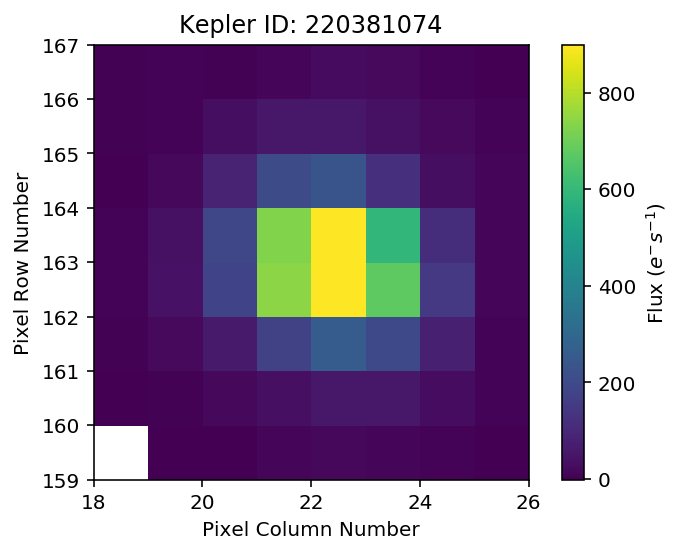

In [40]:
tpf = KeplerTargetPixelFile.from_archive(220381074)
tpf.plot()

Text(0.5,1,'EPIC 220381074')

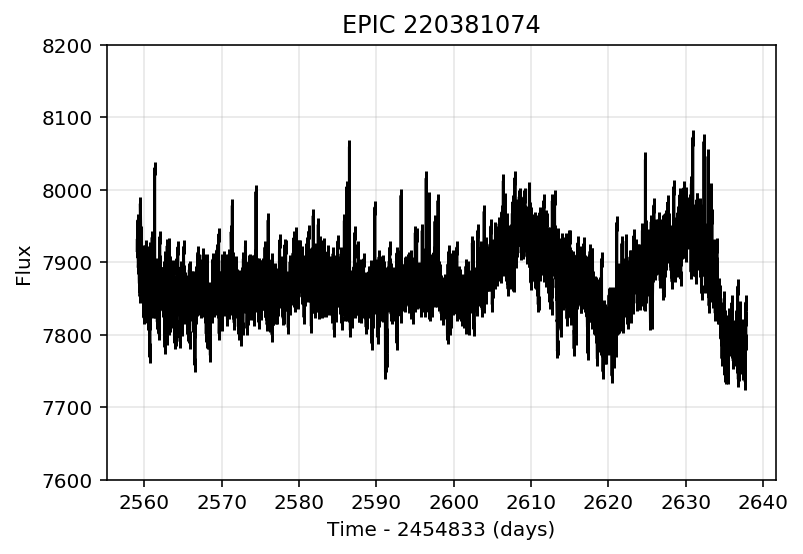

In [41]:
lc = tpf.to_lightcurve(aperture_mask='all')
#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [42]:
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

In [43]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=7.e-7)

In [44]:
model.sn_params

{'amplitude': 7e-07, 't0': 2600, 'z': 0.5}

Let's plot the model by itself. We do this by evaluating it over the initial lightcurve's timestamps, usng the `.evaluate` method:

In [45]:
model_sn_eval = model.evaluate(lc.time)

And now the model injected into our galaxy:

In [46]:
lcinj = lc.inject(model)

In [47]:
lcinj.background

7789.7870898437495

Text(0.5,1,'EPIC 220381074 With SN')

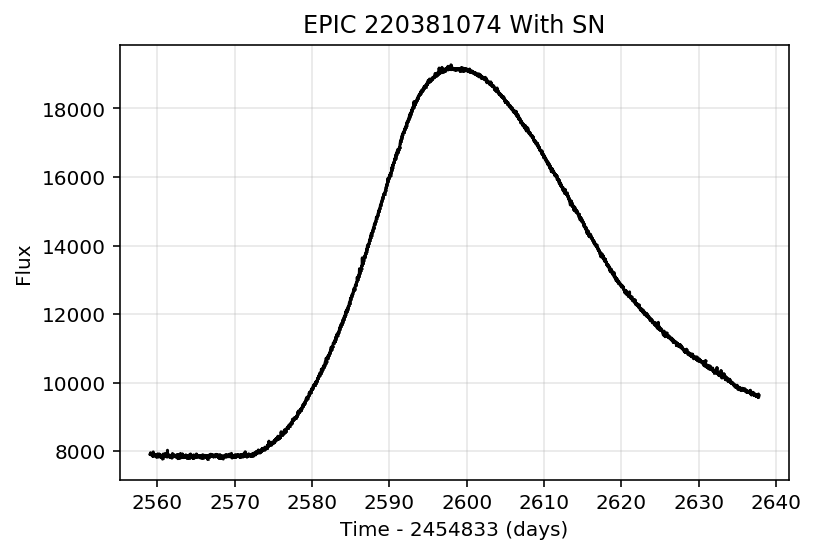

In [48]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

In [49]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [50]:
initial_guess={'T0':2610, 'z':0.5, 'amplitude':2.0e-7, 'background':7800}

In [51]:
%%time
x = lcinj.recover_supernova(fit_params=['T0', 'z', 'background'])


KeyboardInterrupt: 

In [52]:
model_ft = x.evaluate(lc.time)
plt.plot(lc.time, model_ft)

AttributeError: 'Table' object has no attribute 'evaluate'

In [53]:
new_model = inj.SupernovaModel(T0=x['T0'], source='hsiao', bandpass='kepler', z=x['z'], amplitude=x['amplitude'])
new_fit = new_model.evaluate(lc.time) + x['background']


KeyError: 'T0'

In [ ]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

In [ ]:
%%time
sampler = lcinj.recover_supernova(fit_params=['T0', 'z', 'amplitude', 'background'], method='mcmc', nwalkers=8, nsteps=8)


In [ ]:
new_model = inj.SupernovaModel(T0=x['T0'], source='hsiao', bandpass='kepler', z=x['z'], amplitude=8.e-8)
new_fit = new_model.evaluate(lc.time) + x['background']



In [ ]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

In [ ]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['inc', 'per', 'rprs', 'lol']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 4)
fig1.show()

In [54]:
x, y = inj.injection_and_recovery(lc, "Supernova", 
    5, 0.1, T0=2600, z=inj.UniformDistribution(0.1,0.3), 
    amplitude = inj.GaussianDistribution(3.e-7, 1.e-7))

KeyboardInterrupt: 

In [90]:
x, y = inj.injection_and_recovery(lc, "Supernova", 
    5, 0.1, T0=2600, z=inj.UniformDistribution(0.1,0.3), 
    amplitude = inj.GaussianDistribution(3.e-7, 1.e-7))

(2600, 0.16429241874738001, 3.1784046203396065e-07)
['z', 'amplitude']
{'z': 0.2179626094382856, 'amplitude': 3.020774813706823e-07}
{'z': 0.2179626094382856, 'amplitude': 3.020774813706823e-07, 'T0': 2600}
(2600, 0.2646828770683721, 4.054654044968007e-07)
['z', 'amplitude', 'z', 'amplitude']
{'z': 0.26742703830511727, 'amplitude': 4.107541428583859e-07}
{'z': 0.26742703830511727, 'amplitude': 4.107541428583859e-07, 'T0': 2600}
Recovered - T0: 2600 amplitude: 4.05465404497e-07 z: 0.264682877068
(2600, 0.1603168022847837, 3.190964758969768e-07)
['z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude']
{'z': 0.21740885774794627, 'amplitude': 3.0165553041823634e-07}
{'z': 0.21740885774794627, 'amplitude': 3.0165553041823634e-07, 'T0': 2600}
(2600, 0.2459630689549767, 3.123251140670321e-07)
['z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude']
{'z': 0.26394860418639965, 'amplitude': 3.167729315022962e-07}
{'z': 0.26394860418639965, 'amplitude': 3.167729315022962e-07, 'T0': 

In [55]:
import lightkurve.injection as inj

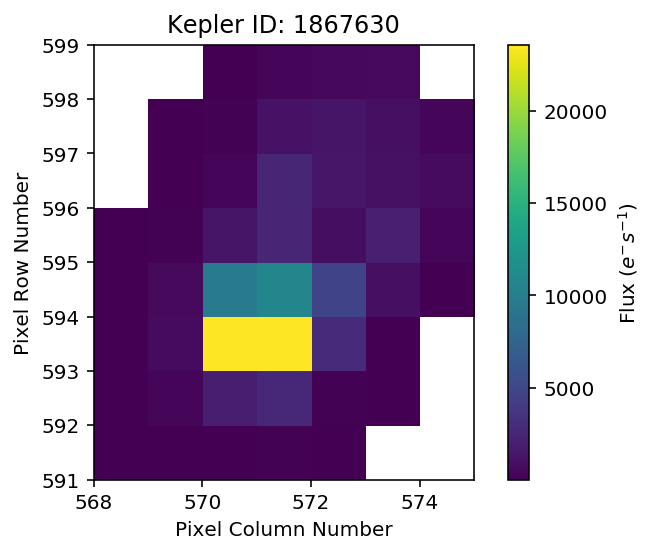

In [56]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

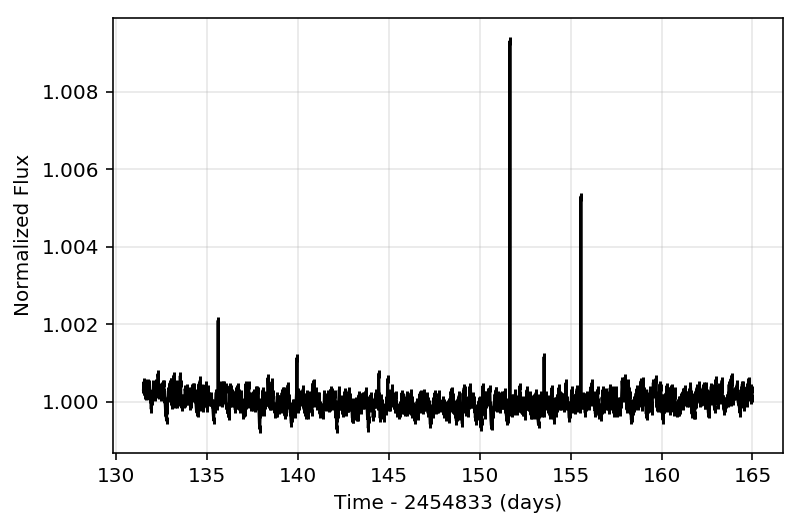

In [57]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

I am going to normalize this light curve, because we are multiplying in a normalized transit lightcurve.

Text(0.5,0,'Time (days)')

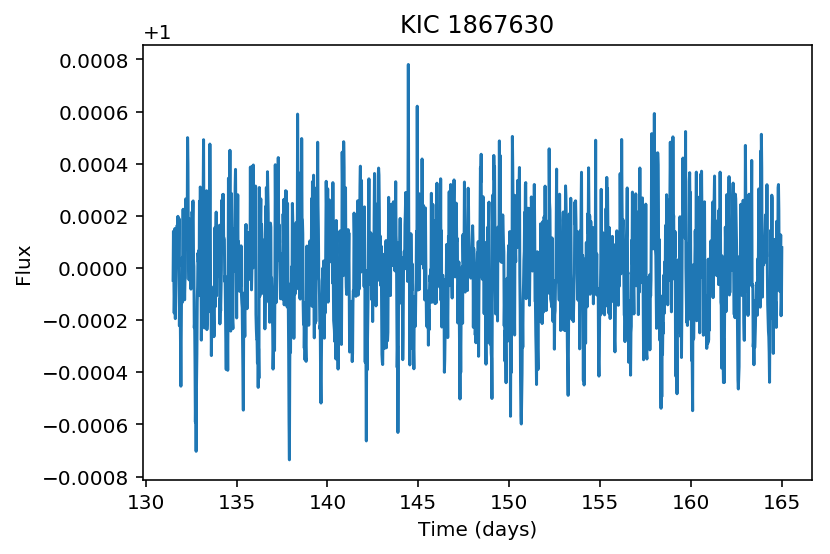

In [58]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm injecting a lightcurve of a Jupiter-sized planet with an orbital period of 5 days.

In [59]:
import batman
from lightkurve.injection import GaussianDistribution

In [60]:
model = inj.TransitModel()
model.add_planet(period=8.680437138294703, rprs=0.14674050301384417, T0=133, inc=87)

In [61]:
lc_transit = lc_star.inject(model)

In [62]:
lc_transit

SyntheticLightCurve: Planet

Let's plot just the model:

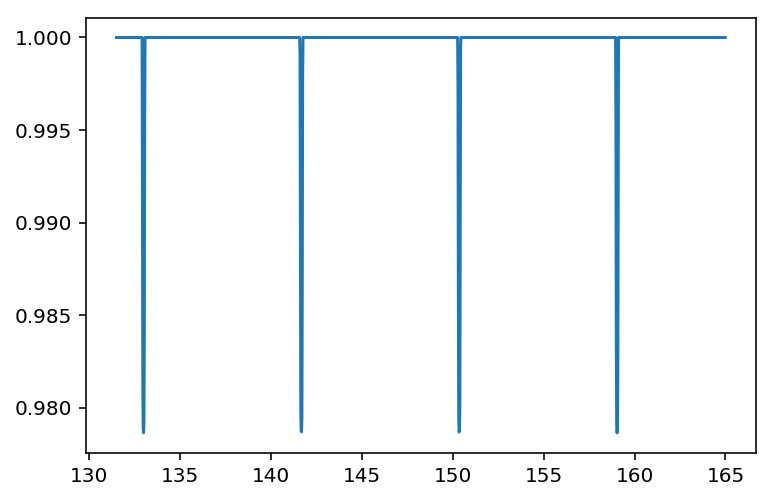

In [63]:
model_eval = model.evaluate(lc_star.time.astype(np.float))
plt.plot(lc_transit.time, model_eval)

And now the injected lightcurve:

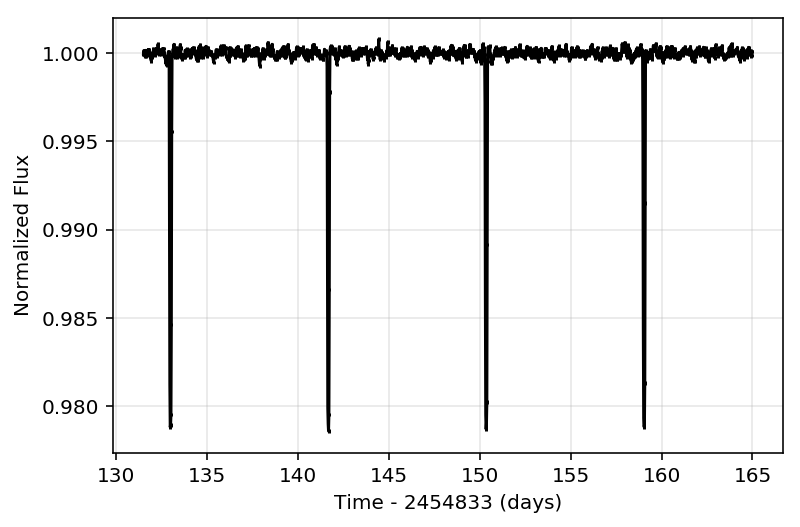

In [64]:
lc_transit.plot()

Now let's recover the transits using the `.recover` method with `signaltype = 'Planet'`.

In [65]:
x = lc_transit.recover_planet(fit_params=['period', 'rprs'])

In [66]:
meval = x.evaluate(lc_transit.time)

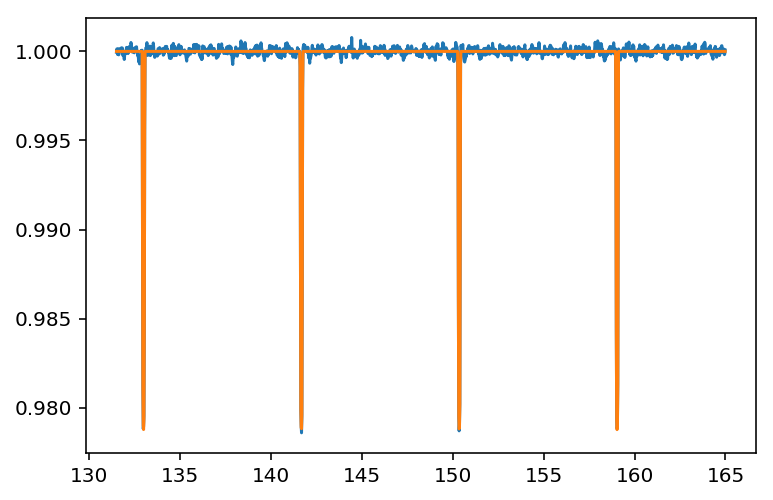

In [67]:
plt.plot(lc_transit.time, lc_transit.flux)
plt.plot(lc_transit.time, meval)

In [68]:
x = inj.injection_and_recovery(lc_star, "Planet", 
    5, 0.03, period=inj.UniformDistribution(5,10), 
    rprs=inj.UniformDistribution(0.1, 0.15), inc=inj.GaussianDistribution(88,0.5))


100%|██████████| 5/5 [00:19<00:00,  3.86s/it]


In [73]:
x

$Recovered$,$Period$,$Rp/Rs$,$To$,$inc$,$a$,$ecc$,$w$
float64,float64,float64,float64,float64,float64,float64,float64
1.0,7.460069417308487,0.1462740331542114,5.0,86.63261791567639,15.0,0.0,90.0
0.0,8.814737658419718,0.13288007815126923,5.0,88.68766760296585,15.0,0.0,90.0
0.0,5.151242413698072,0.12857809375034093,5.0,88.33663485439905,15.0,0.0,90.0
1.0,6.328764026763365,0.10543212732217642,5.0,87.23180981824763,15.0,0.0,90.0
0.0,5.220949451212572,0.1392645874472997,5.0,88.69757939513796,15.0,0.0,90.0
0.0,6.422662266509684,0.14909012151922613,5.0,87.97771620532701,15.0,0.0,90.0
0.0,9.679139744912725,0.13486546776051242,5.0,88.5952252108153,15.0,0.0,90.0
0.0,9.840308926594723,0.14731361326706754,5.0,87.60742266282328,15.0,0.0,90.0
1.0,6.452072971537422,0.14235878251926573,5.0,88.52851014492927,15.0,0.0,90.0


In [66]:
from tqdm import tqdm

2.12-inject-transits-into-lightcurves

# How to simulate a planetary transit in your lightcurve

The K2 mission's primary goal is to discover and study exoplanets around stars in our neighborhood.  In order to discover a planet, it's important to determine our sensitivity to different types of planets around our stars of interest given noise in Kepler and K2 data (sawtooth patterns, rolling band, and even astrophysical artifacts such as stellar rotation and flares). This injection and recovery tool (built upon Laura Kreidberg's `batman` transit simulation package) makes it easy to simulate a planet of any type and add it to a Kepler, K2, or TESS light curve of your choice.

In [80]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import lightkurve.injection as inj

From our TPF, let's create a lightcurve of this G-type star and plot it.

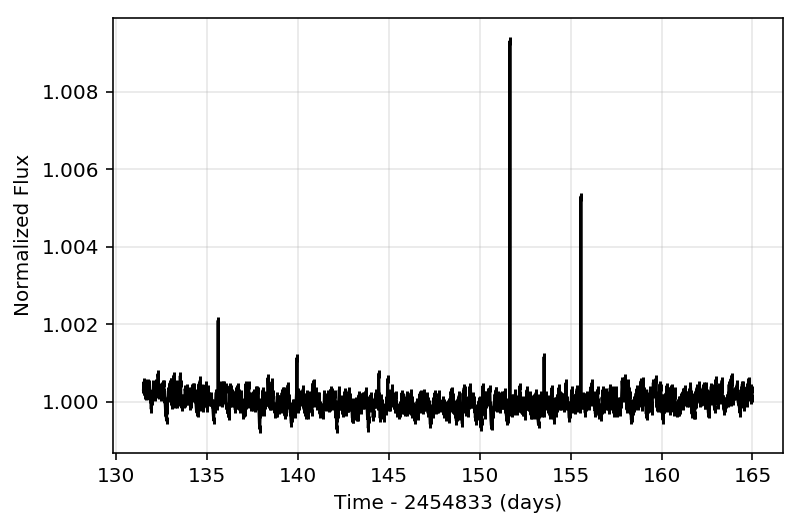

In [82]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

We're going to remove nans and outliers and detrend the light curve using a median filter. (**? is this what `.flatten` does**) We're also going to normalize the lightcurve.  It's important to normalize the lightcurve first because the `.inject` method injects a normalized transit model.

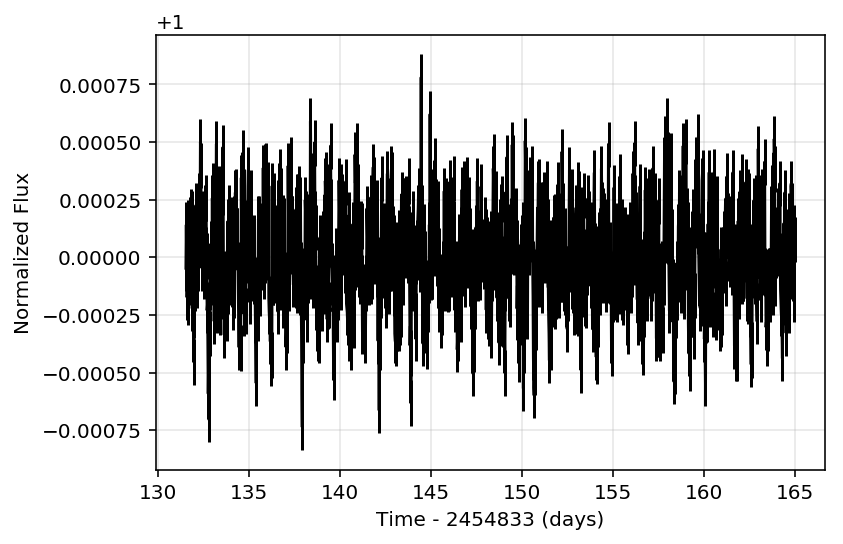

In [83]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

lc_star.plot()

Now let's create a transit model using the `TransitModel` class.  We're going to inject a planet with an orbital period of 12 days, an rp/rs of 0.06, and an inclination of 88.5 degrees. 

In [84]:
model = inj.TransitModel()
model.add_planet(period=9, rprs=0.06, T0=133., inc=88.5)

In [85]:
lc_transit = lc_star.inject(model)

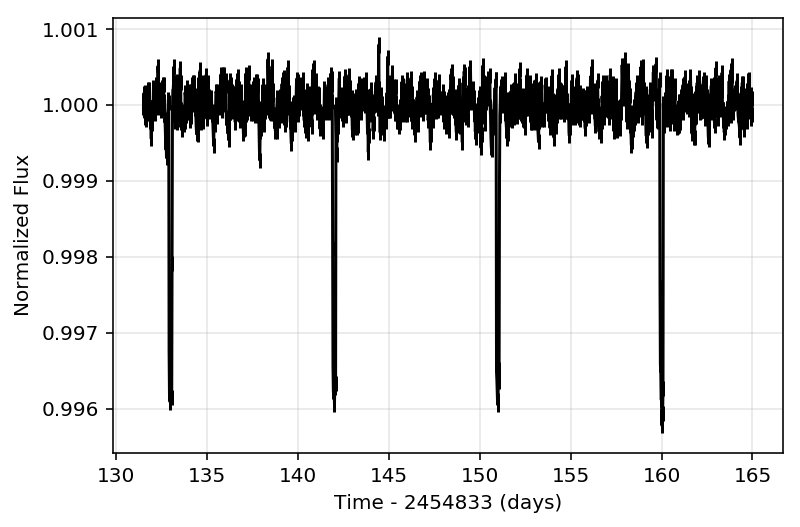

In [86]:
lc_transit.plot()

Let's plot just the model:

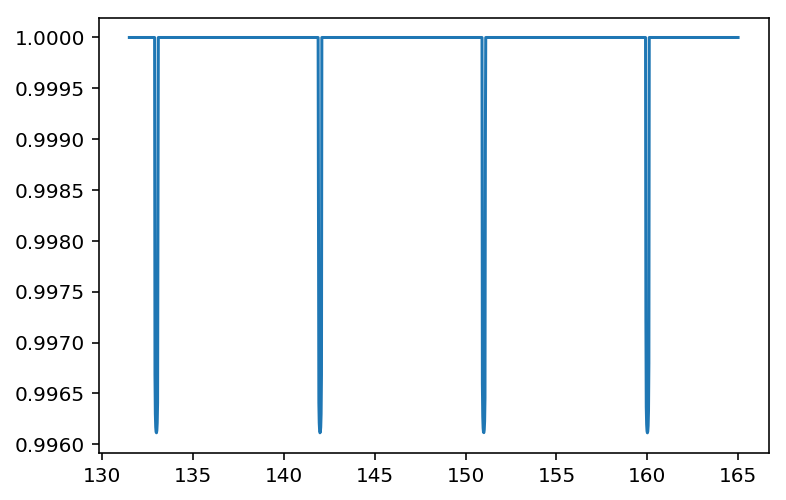

In [87]:
model_eval = model.evaluate(lc_star.time.astype(np.float))
plt.plot(lc_transit.time, model_eval)

And now the injected lightcurve:

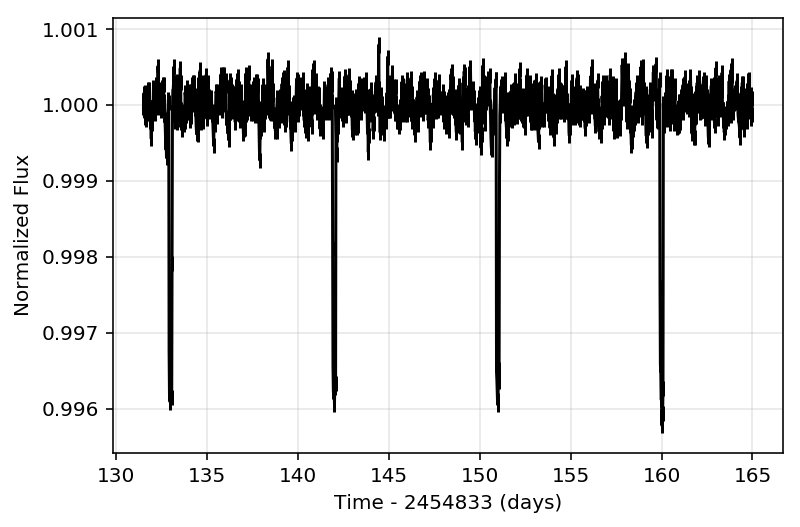

In [88]:
lc_transit.plot()

In [89]:
x = lc_transit.recover_planet(fit_params=['period', 'rprs'])

In [100]:
x.period

9.00032837105634

In [98]:
evaluate = x.evaluate(lc_transit.time)

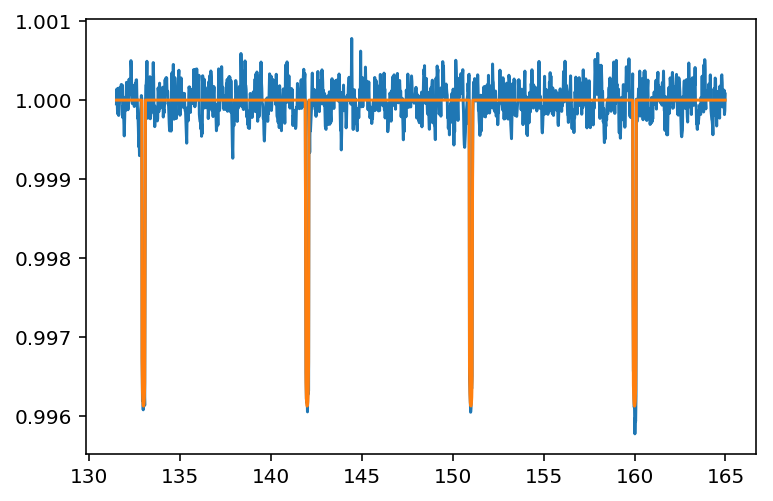

In [99]:
plt.plot(lc_transit.time, lc_transit.flux)
plt.plot(lc_transit.time, evaluate)

In [52]:
meval = x.evaluate(lc_transit.time)

In [187]:
type(x)

astropy.table.table.Table

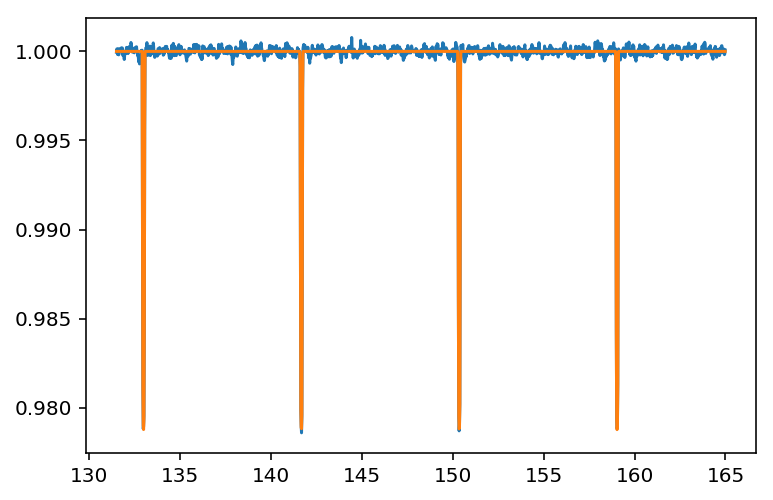

In [54]:
plt.plot(lc_transit.time, lc_transit.flux)
plt.plot(lc_transit.time, meval)